# Dealing with uncertainty using heteroscedastic dropout

In [1]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from src.data import generate_dataset, generate_sin_shaped_dataset
from src.visualization import beautify_ax

%load_ext autoreload
%autoreload 2

# Generating data
Generating a dataset with a increasing variance. This allows to demonstrate differences in uncertainty, which should be higher when x increases.

In [6]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

## Plotting the data

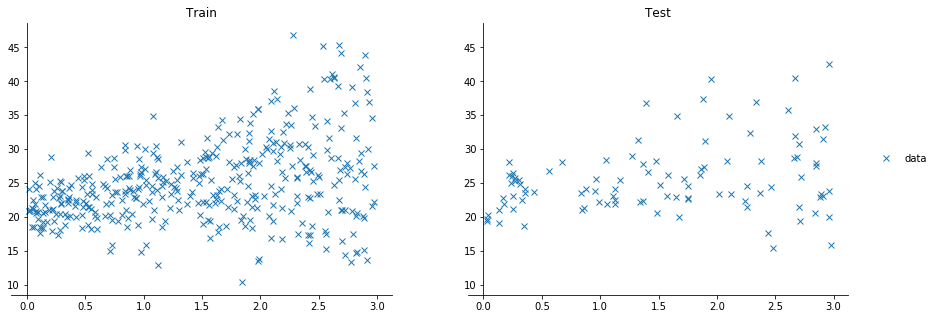

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])  # simple function to format axes as shown below, you can remove this if you prefer
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## You can also try something more difficult...

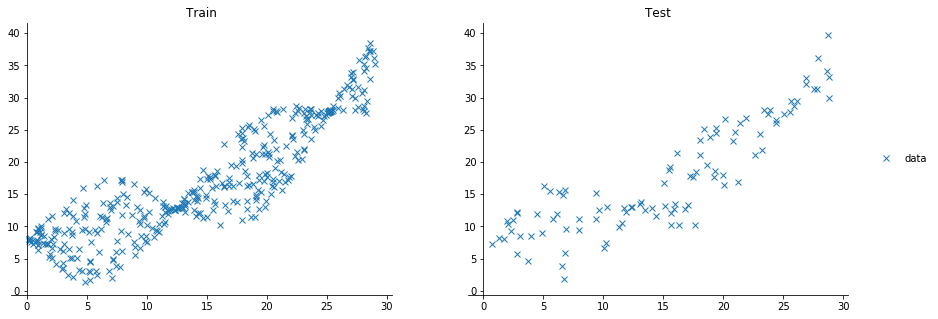

In [4]:
# x, x_test, y, y_test = generate_sin_shaped_dataset(n=500, test_size=.2)

# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

# axes[0] = beautify_ax(axes[0])  # simple function to format axes as shown below, you can remove this if you prefer
# axes[0].plot(x, y, 'x', label='data')
# axes[0].set_title("Train")

# axes[1] = beautify_ax(axes[1])
# axes[1].plot(x_test, y_test, 'x', label='data')
# axes[1].set_title("Test")

# plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Scaling the data
To make sure the feature $x$ and target $y$ are in the same scale

In [8]:
mmsx = MinMaxScaler().fit(x)
x, x_test = mmsx.transform(x), mmsx.transform(x_test)

mmsy = MinMaxScaler().fit(y)
y, y_test = mmsy.transform(y), mmsy.transform(y_test)

In [51]:
class HeteroscedasticDropoutNet(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.hidden_size = params['hidden_size']
        self.model_ = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']),
#             nn.PReLU(),  # when modelling non-linearities
            nn.Dropout(params['dropout_p']),
            nn.Linear(params['hidden_size'], params['output_size'])
        )
        self.optim_ = torch.optim.Adam(
            self.model_.parameters(), 
            lr=params['lr']
        )
    
    def forward(self, X):
        return self.model_(X)
        
    
    def mc_predict(self, X, samples=4000):
        with torch.no_grad():
            self.model_.train()
            preds = torch.stack([self.model_(X) for _ in range(samples)], dim=-1)
        return preds
    
    def save(self, path, fname):
        torch.save({
            "model_state_dict": self.model_.state_dict(),
            "optim_state_dict": self.optim_.state_dict(),
        }, os.path.join(path, fname))
    
    def load(self, path, fname):
        checkpoint = torch.load(os.path.join(path, fname))
        self.model_.load_state_dict(checkpoint['model_state_dict'])
        self.optim_.load_state_dict(checkpoint['optim_state_dict'])
        return self

## Loss and utility functions
- Created a quantile loss function that calculates the loss for all quantiles. 
- A functions that helps creating (evenly spaced) array of 'quantiles'. 

In [53]:
def gaussian_nll_loss(output, target, sigma):
    sigma = torch.exp(sigma)
    
    # The manual way:
#     exp = -((target - output)**2) / (2 * sigma**2)
#     log_coef = -torch.log(sigma)
#     const = -0.5*np.log(2*np.pi)
#     loss = -(exp + log_coef + const).sum()
    
    # The automagic way
    dist = torch.distributions.Normal(output, sigma)  # or another distribution if preferred
    loss = -dist.log_prob(target)
    
    return loss.sum()

## Model setup

In [54]:
params = {
    'input_size': 1,
    'output_size': 2,
    'hidden_size': 256,
    'dropout_p': 0.2,
    'batch_size': 128,
    'epochs': 2001,
    'lr': 1e-4,
}
model = HeteroscedasticDropoutNet(params)
criterion = gaussian_nll_loss

## Training the model

In [55]:
x_train, y_train = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

In [57]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        output = model(x_batch)
        loss = criterion(output[:, :1], y_batch, output[:, 1:])
        loss.backward()
        model.optim_.step()
        model.optim_.zero_grad()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            output_train = model(x_train)
            mean_train = mean_absolute_error(y_train, output_train[:, :1])
            train_loss = criterion(output_train[:, :1], y_train, output_train[:, 1:])
            output_val = model(x_val)
            mean_val = mean_absolute_error(y_val, output_val[:, :1])
            val_loss = criterion(output_val[:, :1], y_val, output_val[:, 1:])
    
        print(f"Epoch: {epoch} \t Train loss:{train_loss:.5f} \t Val loss: {val_loss:.5f} \t MAE train: {mean_train:.5f} \t MAE val: {mean_val:.5f}")

Epoch: 0 	 Train loss:452.26453 	 Val loss: 114.08157 	 MAE train: 0.33347 	 MAE val: 0.34017
Epoch: 100 	 Train loss:-182.54964 	 Val loss: -46.75988 	 MAE train: 0.11316 	 MAE val: 0.10607
Epoch: 200 	 Train loss:-227.73769 	 Val loss: -58.43923 	 MAE train: 0.11305 	 MAE val: 0.10526
Epoch: 300 	 Train loss:-245.67612 	 Val loss: -61.95584 	 MAE train: 0.11316 	 MAE val: 0.10648
Epoch: 400 	 Train loss:-253.14374 	 Val loss: -64.04665 	 MAE train: 0.11316 	 MAE val: 0.10639
Epoch: 500 	 Train loss:-254.97469 	 Val loss: -63.72997 	 MAE train: 0.11310 	 MAE val: 0.10634
Epoch: 600 	 Train loss:-256.57428 	 Val loss: -65.32269 	 MAE train: 0.11311 	 MAE val: 0.10607
Epoch: 700 	 Train loss:-255.97462 	 Val loss: -63.91346 	 MAE train: 0.11314 	 MAE val: 0.10643
Epoch: 800 	 Train loss:-256.18420 	 Val loss: -63.56537 	 MAE train: 0.11315 	 MAE val: 0.10634
Epoch: 900 	 Train loss:-255.62453 	 Val loss: -62.88954 	 MAE train: 0.11327 	 MAE val: 0.10682
Epoch: 1000 	 Train loss:-255.282

## Predicting on the train and validation set

In [58]:
preds_train = model.mc_predict(x_train, samples=4000).numpy()
preds_val = model.mc_predict(x_val, samples=4000).numpy()

si_train = x_train.argsort(dim=0).flatten()
train_x_, train_y_hat = x_train[si_train].numpy(), preds_train[si_train, :, :]
train_y_ = y_train[si_train].numpy()

si_val = x_val.argsort(dim=0).flatten()
val_x_, val_y_hat = x_val[si_val].numpy(), preds_val[si_val, :, :]
val_y_ = y_val[si_val].numpy()

In [59]:
def postprocess_samples(samples):
    mus = np.mean(samples[:, 0, :], axis=-1)
    sigmas = np.mean(np.exp(samples[:, 1, :]), axis=-1)
    return mus, sigmas

pred_mu_train, pred_sigma_train = postprocess_samples(train_y_hat)
pred_mu_val, pred_sigma_val = postprocess_samples(val_y_hat)

## Plotting different types of uncertainty

In [61]:
# Dealing with the samples
sampled_mus = train_y_hat[:, 0, :]
mean_mus = sampled_mus.mean(axis=-1)
noises = np.exp(train_y_hat[:, 1, :])

# calculating different uncertainties
aleatoric = (noises**2).mean(axis=-1)**0.5
epistemic = (sampled_mus.std(axis=-1))

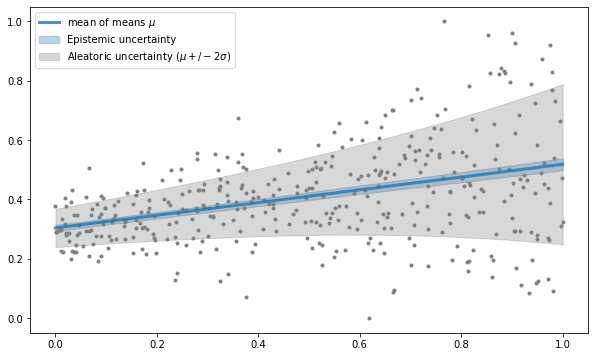

In [62]:
upper_ep = mean_mus + epistemic
lower_ep = mean_mus - epistemic
upper_total = mean_mus + aleatoric  # + 1 sigma
lower_total = mean_mus - aleatoric  # - 1 sigma

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o', c='grey', markersize=3)
plt.plot(train_x_, mean_mus, lw=3, color='tab:blue', alpha=.8, label='mean of means $\mu$')
plt.fill_between(train_x_.flatten(), lower_ep, upper_ep, alpha=.3, color='tab:blue', label='Epistemic uncertainty')
plt.fill_between(train_x_.flatten(), lower_total, upper_total, alpha=.3, color='grey', label='Aleatoric uncertainty ($\mu +/- 2\sigma$)')
# plt.fill_between(train_x_.flatten(), upper_ep, upper_total, alpha=.3, color='grey')
plt.legend();

## Saving model state

In [63]:
model.save(path='../models/', fname='heteroscedastic_mcdropout.pth')

In [65]:
model = HeteroscedasticDropoutNet(params)
model.load(path='../models/', fname='heteroscedastic_mcdropout.pth')

HeteroscedasticDropoutNet(
  (model_): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
  (input_layer): Linear(in_features=1, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)

## Plotting individual predicted probability distributions
In original data scale. Be aware that you cannot use `inverse_transform()` to transform the sigma back to it's original scale.

[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn-preprocessing-minmaxscaler) scales like this:
```
(X - X.min()) / (X.max() - X.min())
```
when using `inverse_transform()` you multiply `X` with `(X.max() - X.min()`, and add `X.min()`. This last addition should not be added to the standard deviation. Therefore you should only use the `.scale_` attribute of the `MinMaxScaler()`. (SKlearn cakculates the scale by:
```
(1 - 0) / (X.max() - X.min())  # if feature_range=(0,1)
```
You should therefore devide by `.scale_` attribute.

In [68]:
# transform values back to original scale
org_x = mmsx.inverse_transform(val_x_)
org_y = mmsy.inverse_transform(val_y_)  
inv_pred_mu_val = mmsy.inverse_transform(pred_mu_val.reshape(-1,1)).flatten()
inv_pred_sigma_val = pred_sigma_val / mmsy.scale_  

# take 9 random sample (indices)
random_is = np.random.randint(0, len(val_x_), 9)

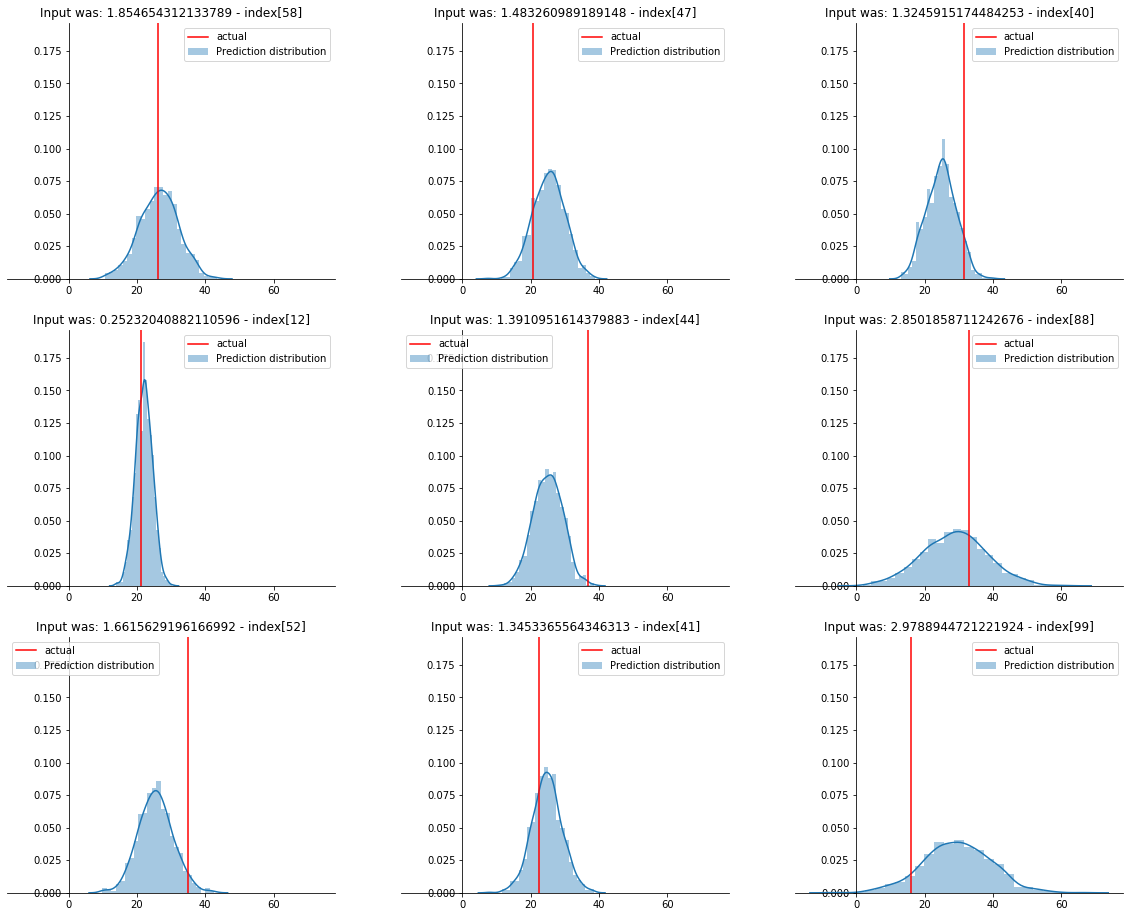

In [76]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    pred_norm = stats.norm.rvs(size=1000, loc=inv_pred_mu_val[i], scale=inv_pred_sigma_val[i])
    sns.distplot(pred_norm, bins=25, ax=ax, label='Prediction distribution')
    ax.axvline(org_y[i], c='r', label='actual')
    ax.set_title(f"Input was: {org_x[i][0]} - index[{i}]")
    ax.legend();

## Extra
In case we want to get similar results as the MCDQRNN (see notebook 1.0). In this case, we do it exactly the other way around. We first parameterize the posterior distribution (and sample from it), and then we can estimate the quantiles (no quantile crossover!).

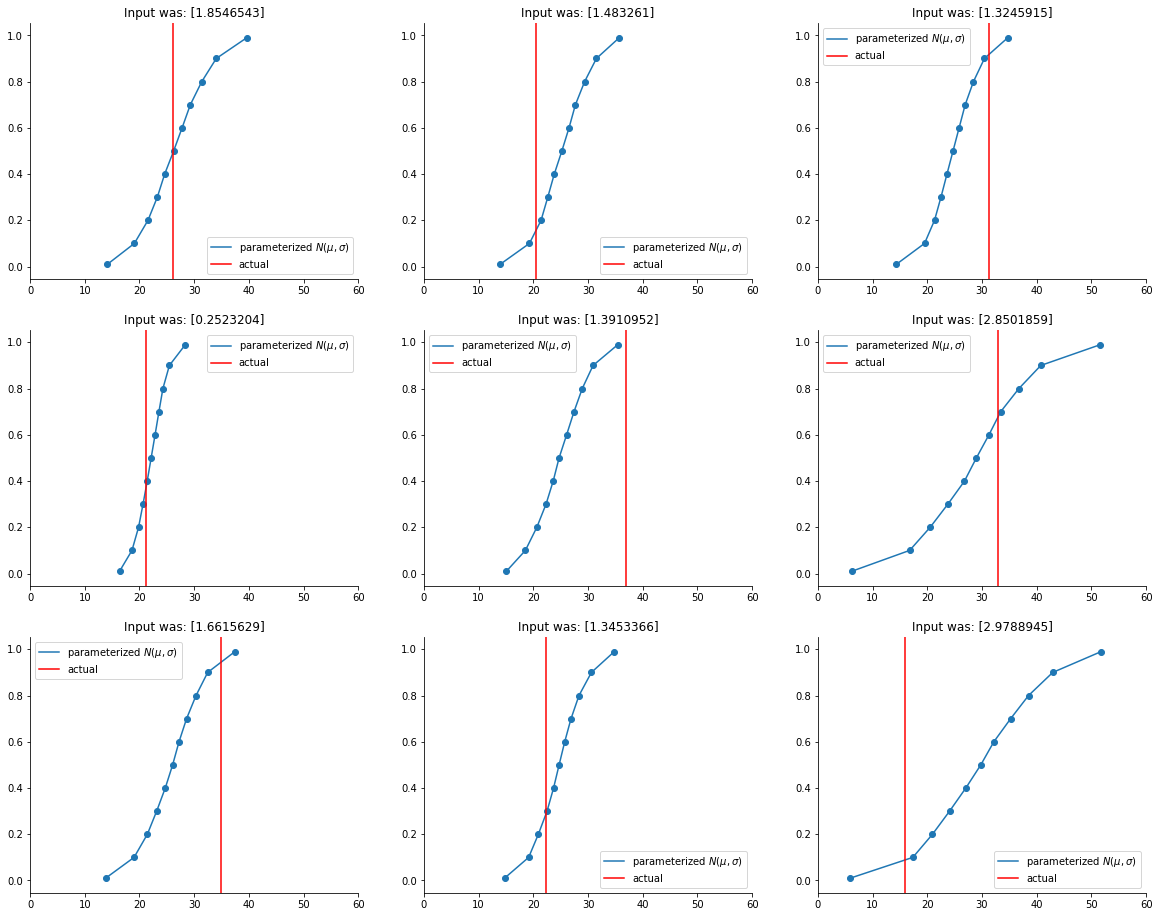

In [77]:
from src.models.quantile_utils import create_quantiles
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))    
    
for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    pred_norm = stats.norm.rvs(size=1000, loc=inv_pred_mu_val[i], scale=inv_pred_sigma_val[i])
    qs_from_posterior = np.quantile(pred_norm, QUANTILES)
    ax.plot(qs_from_posterior, QUANTILES, label='parameterized $N(\mu,\sigma$)')
    ax.scatter(qs_from_posterior, QUANTILES)
    ax.axvline(org_y[i], c='r', label='actual')
    ax.set_title(f"Input was: {org_x[i]}")
    ax.set_xlim(0, 60)
    ax.legend()
    
plt.show()